# OSCAR Calibration
### Generates incidence angle dependent NRCS and Interferogram calibration curves
### Saves calibration datasets as NetCDF files 

In [2]:
import xarray as xr
import numpy as np
import scipy as sp
import seastar as ss
import pandas as pd
import warnings
import os
from _version import __version__
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from _version import __version__
from datetime import datetime
from scipy.optimize import curve_fit
import matplotlib as mpl
from seastar.utils.tools import db2lin as db2lin
from seastar.utils.tools import lin2db as lin2db
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from time import time
import matplotlib.path as mpltPath
from scipy import interpolate
import platform
import re
def iqr(da, dim):
    """Calculates interquartile range"""
    return (da.quantile(q=0.75, dim=dim) - da.quantile(q=0.25, dim=dim)).rename("iqr")
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def add_attributes(ds):
    ds['Antenna'].attrs['long_name']  = 'Antenna'
    ds['Antenna'].attrs['units']  = ''
    ds['Antenna'].attrs['description']  = 'Name of OSCAR antenna location'
    ds['IncidenceAngle'].attrs['long_name'] = 'Incidence angle'
    ds['IncidenceAngle'].attrs['units'] = 'deg'
    ds['IncidenceAngle'].attrs['description'] = 'Incidence angle between nadir and the ground'
    if 'Sigma0' in ds.variables:
        ds['Sigma0'].attrs['long_name'] = 'Sigma0 bias'
        ds['Sigma0'].attrs['description'] = 'Sigma0 bias with GMF'
        ds['Sigma0'].attrs['units'] = ''
    if 'Interferogram' in ds.variables:
        ds['Interferogram'].attrs['long_name'] = 'Interferogram bias'
        ds['Interferogram'].attrs['description'] = 'Azimuth-averaged Interferogram with respect to IncidenceAngle from star pattern fit'
        ds['Interferogram'].attrs['units'] = 'rad'
    ds.attrs['Codebase'] = 'seastar_project'
    ds.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
    ds.attrs['CodeVersion'] = __version__
    ds.attrs['DataVersion'] = version
    ds.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')
    ds.attrs['NRCSGMF'] = 'NSCAT-4DS'
    return ds

def add_track_attributes(ds):
    ds['FilesUsed'] = xr.DataArray(data=build_tracks_used_file_list(['Track_' + str(track) for track in tracks_to_process]),
            coords={'Track':['Track_' + str(track) for track in tracks_to_process]},
            )
    ds['FilesUsed'].attrs['long_name'] = 'Files used'
    ds['FilesUsed'].attrs['description'] = 'Files used in ocean calibration star pattern fit'
    ds['FilesUsed'].attrs['units'] = ''
    ds.attrs['ReducedTrackLength'] = str(reduce_track_length)
    ds['StartTime'] = xr.DataArray(data=[format(ds_L1b[track].OrbTimeImage.sel(Antenna='Mid').mean(dim='GroundRange')[0].data, '.2f')
                                                  for track in ['Track_' + str(track) for track in tracks_to_process]],
                                            coords = ds.FilesUsed.coords,
                                           )
    ds['StartTime'].attrs['long_name'] = 'Start times'
    ds['StartTime'].attrs['description'] = 'Start times (GPS sec week) for each track used in ocean calibration star pattern fit'
    ds['StartTime'].attrs['units'] = 's'
    ds['EndTime'] = xr.DataArray(data=[format(ds_L1b[track].OrbTimeImage.sel(Antenna='Mid').mean(dim='GroundRange')[-1].data, '.2f')
                                                  for track in ['Track_' + str(track) for track in tracks_to_process]],
                                            coords = ds.FilesUsed.coords,
                                           )
    ds['EndTime'].attrs['long_name'] = 'End times'
    ds['EndTime'].attrs['description'] = 'End times (GPS sec week) for each track used in ocean calibration star pattern fit'
    ds['EndTime'].attrs['units'] = 's'
    ds['Track'].attrs['long_name'] = 'Tracks used'
    ds['Track'].attrs['description'] = 'Names of tracks used in star pattern fit for ocean calibration'
    ds['Track'].attrs['units'] = ''
    return ds

def reduced_track_timestr(start_time_string_new, end_time_string_new):
    pattern = r'(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<hour>\d{2}):(?P<minute>\d{2})'
    match_start = re.match(pattern, str(start_time_string_new))
    match_end = re.match(pattern, str(end_time_string_new))
    timestr = ''.join([match_start.group('year'),match_start.group('month'),match_start.group('day')])+'T'+'-'.join([match_start.group('hour')+match_start.group('minute'),                                                                                               match_end.group('hour')+match_end.group('minute')])
    return timestr
def timestrings(StartTime, EndTime):
    start_time_string = '-'.join([StartTime[0:4], StartTime[4:6],StartTime[6:8]]) + 'T' + ':'.join([StartTime[9:11], StartTime[11:13]])
    end_time_string = '-'.join([EndTime[0:4], EndTime[4:6],EndTime[6:8]]) + 'T' + ':'.join([EndTime[9:11], EndTime[11:13]])
    return start_time_string, end_time_string
def build_tracks_used_file_list(tracks):
    tracks_used_file_list = []
    for track in tracks:
        pattern = rf'.*_{re.escape(track)}_.*'
        tracks_used_file_list.append([f for f in L1B_file_list if re.match(pattern, f)][0])
    return tracks_used_file_list

def fit_func_simple(az, A, B, C, f):
    g = A * (
            1\
            + np.sign(A)*B*np.cos(np.radians(az-f))\
            + np.sign(A)*C*np.cos(np.radians(2*(az-f)))
        )
    return(g.ravel())
def fit_func_simple2(az, A, B, C, f):
    g = A   + B*np.cos(np.radians(az-f))\
            + C*np.cos(np.radians(2*(az-f))
        )
    return(g.ravel())

def star_pattern_analysis(ds_L1b, vars_list, coords_list, tracks, u10, updir, 
                           exclude_tracks = False, tracks_to_exclude = [None],
                         ):
    exclude_tracks = False
    track_names_list = ['Track_' + str(track) for track in tracks]
    dsl2 = [None] * len(track_names_list)
    for ii, track in enumerate(track_names_list):
        dsl2[ii] = ds_L1b[track][vars_list + coords_list]
    # check to see what interp_like changes, make sure there is no funny business 
    for ii in range(1,len(dsl2)):
        dsl2[ii] = dsl2[ii].interp_like(dsl2[0])
    L1 = xr.concat(dsl2, dim='Track')
    L1['Track'] = tracks
    del dsl2
    med = L1.sel(Track=tracks)[vars_list + coords_list].median(dim='CrossRange')
    med = med.set_coords(coords_list)
    siqr = L1\
        .sel(Track=tracks)[vars_list + coords_list]\
        .map(iqr, dim='CrossRange')
    siqr = siqr.set_coords(coords_list)
    siqr['IncidenceAngleImage'] = med.IncidenceAngleImage.copy()
    inci_bins = np.arange(20.5, 71.5, 1)
    inci_center = np.arange(21, 71, 1)
#     var_list = ['Sigma0', 'Interferogram','Coherence','RadialSurfaceVelocity'] # ADD TO FUNCTIONS VARIABLES
    var_list = list(set(vars_list) & set(['Sigma0', 'Interferogram','Coherence','RadialSurfaceVelocity']))
    data = dict()
    errors = dict()
    azimuth = np.zeros((med.Track.size, med.Antenna.size))
    for var in var_list:
        data[var] = np.ones((med.Track.size, med.Antenna.size, len(inci_center)))
        errors[var] = np.ones((siqr.Track.size, siqr.Antenna.size, len(inci_center)))
        for itrack, track in enumerate(med.Track.data):
            for iantenna, antenna in enumerate(med.Antenna.data):
                azimuth[itrack, iantenna] = med.AntennaAzimuthImage.sel(Track=track, Antenna=antenna).mean().data
                data[var][itrack, iantenna, :] = med[var].sel(Track=track, Antenna=antenna)\
                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
                errors[var][itrack, iantenna, :] = siqr[var].sel(Track=track, Antenna=antenna)\
                    .groupby_bins('IncidenceAngleImage', inci_bins, labels=inci_center).mean().data
    nds = dict()
    nerr = dict()
#     var_list = ['Sigma0', 'Interferogram','Coherence','RadialSurfaceVelocity']
    for var in var_list:
        nds[var] = xr.Dataset({var: (["Track", "Antenna", "inci"], data[var] )},
                           coords={"azimuth": (["Track", "Antenna"], azimuth),
                                   "inci": (["inci"], inci_center),
                                   "Track": (["Track"], med.Track.data),
                                   "Antenna": (["Antenna"], med.Antenna.data),
                                  }
                           )
        nerr[var] = xr.Dataset({var: (["Track", "Antenna", "inci"], errors[var] )},
                           coords={"azimuth": (["Track", "Antenna"], azimuth),
                                   "inci": (["inci"], inci_center),
                                   "Track": (["Track"], med.Track.data),
                                   "Antenna": (["Antenna"], med.Antenna.data),
                                  }
                           )
    if 'Sigma0' in data.keys():
        nds['Sigma0'] = 10*np.log10(nds['Sigma0'])
    nds = xr.merge([nds[var] for var in nds.keys()], compat='no_conflicts', join='outer')
    nerr = xr.merge([nerr[var] for var in nerr.keys()], compat='no_conflicts', join='outer')  
    inci_joint = np.arange(25,66)
    az = np.arange(0,360)
    ones = np.ones(np.size(az))
    nb_parameters = 4
    popt = dict()
    for var in var_list:
        popt[var] = np.zeros((med.Antenna.size, len(inci_joint), nb_parameters))
    p0 = [1,1,1,1]
    for var in var_list:
        for iantenna, antenna in enumerate(med.Antenna):
            for ii, inci_value in enumerate(inci_joint):
                lds = nds.sel(Antenna=antenna, inci=inci_value)
                if var == 'Sigma0':
                    if not np.isnan(lds.Sigma0.data.ravel()).all():
                        valid = ~np.isnan(lds.Sigma0.data.ravel())
                        if exclude_tracks:
                            for i in tracks_to_exclude:
                                valid[i-1] = False
                        p0, pcov = curve_fit(fit_func_simple,
                                             az,
                        10*np.log10(ss.gmfs.nrcs.nscat4ds(u10*ones,
                                                          np.abs(np.mod(az - updir +180, 360) - 180),
                                                          inci_value*ones,
                                                          ones)),
                                            )
                        popt['Sigma0'][iantenna, ii, :], pcov = curve_fit( 
                            fit_func_simple, lds.azimuth.data.ravel()[valid], lds.Sigma0.data.ravel()[valid],
                            check_finite=True, 
                            p0=p0, 
    #                         bounds=([-50, 0, 0, 0], [+10, 1, 1, 360])
                        )
                else:
                    if not antenna.data[()] == 'Mid':
                        valid = ~np.isnan(lds[var].data.ravel())
                        if exclude_tracks:
                            for i in tracks_to_exclude:
                                valid[i-1] = False
                        if var == 'Interferogram':
                            popt[var][iantenna, ii, :], pcov = curve_fit(
                                fit_func_simple2, lds.azimuth.data.ravel()[valid], lds[var].data.ravel()[valid],
                            maxfev = 100000)
                        else:
                            popt[var][iantenna, ii, :], pcov = curve_fit(
                                fit_func_simple, lds.azimuth.data.ravel()[valid], lds[var].data.ravel()[valid],p0 = p0,
                                maxfev = 100000)
                            p0 = popt[var][iantenna,ii]
    fit = dict()
    for var in var_list:
        fit[var] = xr.Dataset({var: (["Antenna", "inci", "parameters"], popt[var])},
                           coords={"parameters": (["parameters"], ["A", "B", "C", "f"]),
                               "inci": (["inci"], inci_joint),
                               "Antenna": (["Antenna"], med.Antenna.data)})
    fit = xr.merge([fit[var] for var in fit.keys()], compat='no_conflicts', join='outer')
    return nds, nerr, fit
def compute_land_mask_from_GSHHS(da, skip):

    boundary = [np.min(da.longitude.data),
                np.max(da.longitude.data),
                np.min(da.latitude.data),
                np.max(da.latitude.data)]
    lon_skip, lat_skip = np.meshgrid(np.arange(boundary[0], boundary[1], skip),
                                     np.arange(boundary[2], boundary[3], skip))
    
    coast_polygons = dict()
    m, n = lon_skip.shape
    mask = np.full((m, n), False).ravel()
    print('Scanning GSHHS dataset for coastlines within boundary...')
    coast = cfeature.GSHHSFeature(scale='full').intersecting_geometries(boundary)
    for k, polygon in enumerate(coast):
        coast_polygons[k] = polygon
    
    xy = coast_polygons[0].exterior.coords.xy
    
    start_time = time()
    path = mpltPath.Path(np.array([np.array(xy).T[:,0],np.array(xy).T[:,1]]).T)
    inside = path.contains_points(np.array([list(lon_skip.ravel()),list(lat_skip.ravel())]).T)
    print("Elapsed time: " + str(time()-start_time))
    
    mask = xr.DataArray(
        data=interpolate.griddata(
            points=(np.ravel(lon_skip),
                    np.ravel(lat_skip)),
            values=(np.ravel(inside)),
            xi=(da.longitude.values,
                da.latitude.values),
            method='nearest'
        ),
        dims=da.dims,
        coords=da.coords
    )
    return mask
def find_exact_track(files, track):
    escaped_track = re.escape(track)
    # Match the exact string followed by _ or . or end of string, but NOT more letters/numbers
    pattern = rf'{escaped_track}(?=(_|\.|$))'
    return [f for f in files if re.search(pattern, f)]



# Load OSCAR data

In [3]:
reduce_track_length = True
file_paths = ss.utils.readers._read_config(config_file='config_LIVPC169.ini')
print('----------------------')
platform = 'OSCAR'
campaign = '202305_MedSea'
processing_level = 'L1B'
version = 'v20250312'
resolution = '056x056m'
flight = '20230508'

L1B_path = os.path.join(file_paths['oscar_path'], campaign, processing_level, version, flight)
track_times = ss.utils.readers.read_OSCAR_track_names_config(campaign, flight)
L1B_track_names = list(track_times.values())
L1B_file_list = os.listdir(L1B_path)
ds_L1b = dict()
start_times = dict()
end_times = dict()
for track in L1B_track_names:
    L1B_file_name = find_exact_track(L1B_file_list, track)[0]
    print('Loading ' + L1B_file_name)
    ds_L1b[track] = xr.open_dataset(os.path.join(L1B_path, L1B_file_name))
    ds_L1b[track]['Sigma0'] = ds_L1b[track].Intensity.copy()
    if reduce_track_length:
        track_length = len(ds_L1b[track].CrossRange)
        start_times[track] = np.nanmin(ds_L1b[track].OrbTimeImage.sel(Antenna='Mid'))
        end_times[track] = np.nanmax(ds_L1b[track].OrbTimeImage.sel(Antenna='Mid'))
        ds_L1b[track] = ds_L1b[track].sel(
            CrossRange = ds_L1b[track].CrossRange[int(track_length / 2) - 400 : int(track_length / 2 + 400)]
        )
print('...Done')

Device name = LIVPC169
Setting local paths...
----------------------
Loading 20230508T1427-1434_OSCAR_L1B_Track_L1_056x056m_2025.04.1.nc
Loading 20230508T1458-1514_OSCAR_L1B_Track_1_056x056m_2025.04.1.nc
Loading 20230508T1518-1528_OSCAR_L1B_Track_2_056x056m_2025.04.1.nc
Loading 20230508T1533-1546_OSCAR_L1B_Track_3_056x056m_2025.04.1.nc
Loading 20230508T1551-1600_OSCAR_L1B_Track_4_056x056m_2025.04.1.nc
Loading 20230508T1605-1617_OSCAR_L1B_Track_5_056x056m_2025.04.1.nc
Loading 20230508T1632-1643_OSCAR_L1B_Track_6_056x056m_2025.04.1.nc
Loading 20230508T1648-1659_OSCAR_L1B_Track_7_056x056m_2025.04.1.nc
Loading 20230508T1703-1715_OSCAR_L1B_Track_8_056x056m_2025.04.1.nc
Loading 20230508T1720-1730_OSCAR_L1B_Track_9_056x056m_2025.04.1.nc
Loading 20230508T1734-1747_OSCAR_L1B_Track_10_056x056m_2025.04.1.nc
Loading 20230508T1751-1800_OSCAR_L1B_Track_11_056x056m_2025.04.1.nc
Loading 20230508T1804-1817_OSCAR_L1B_Track_12_056x056m_2025.04.1.nc
Loading 20230508T1821-1832_OSCAR_L1B_Track_13_056x056m_2

# Land phase Calibration
### Scans for coastlines within the L1B data using the GSHHS global coastline dataset, finds land pixels within these coastline polygons to generate land masks. Generates incidence angle dependent interferogram bias curves by applying these land masks and then smoothin the along-track median interferograms with a polynomial.
### Generates a land calib dataset

Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 0.0016851425170898438
Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 0.023616313934326172
Scanning GSHHS dataset for coastlines within boundary...
Elapsed time: 0.023395061492919922


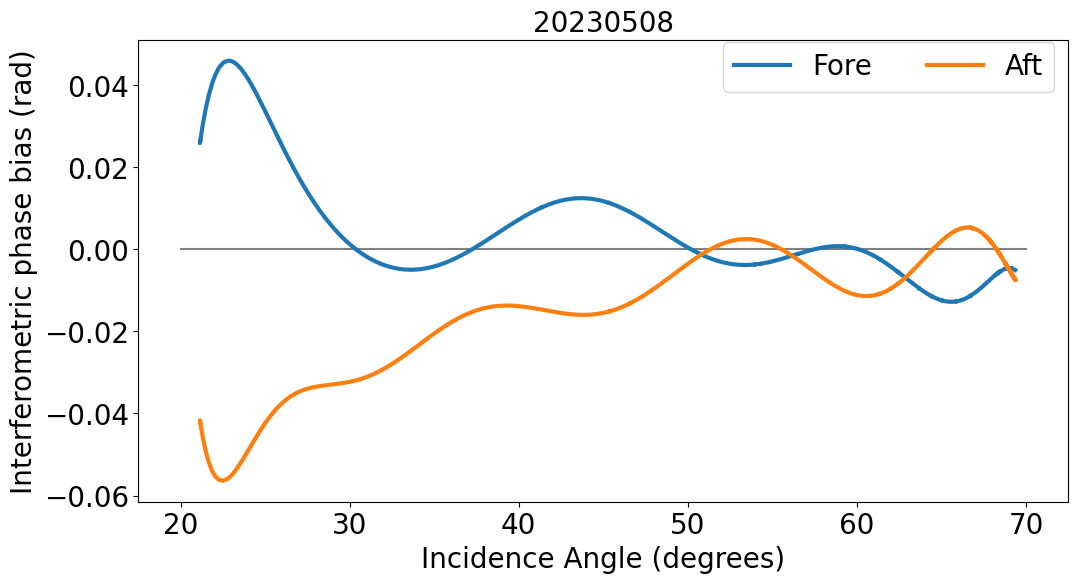

...Done


In [10]:
land_track = 'Track_L1'

ds_L1b_land = ds_L1b[land_track]
mask_mid = compute_land_mask_from_GSHHS(ds_L1b_land.Interferogram.sel(Antenna='Mid'),skip=1/250)
mask_fore = compute_land_mask_from_GSHHS(ds_L1b_land.Interferogram.sel(Antenna='Fore'),skip=1/1000)
mask_aft = compute_land_mask_from_GSHHS(ds_L1b_land.Interferogram.sel(Antenna='Aft'),skip=1/1000)
ds_L1b_land['LandMask'] = xr.concat([mask_mid, mask_fore, mask_aft],'Antenna',join='outer')

phase = ds_L1b_land.Interferogram.where(ds_L1b_land.LandMask==1).median(dim='CrossRange')
incidence_angle = ds_L1b_land.IncidenceAngleImage.where(ds_L1b_land.LandMask==1).median(dim='CrossRange')

incidence_angle = xr.concat(incidence_angle, dim='Antenna')
ds_phase = xr.merge([phase, incidence_angle])

ds_LandCalib = xr.Dataset()
ds_LandCalib['Interferogram'] = xr.concat([xr.DataArray(
    data=ds_phase.sel(Antenna=['Fore']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                       xr.DataArray(
    data=np.zeros(ds_phase.sel(Antenna=['Fore']).Interferogram.data.size),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                       xr.DataArray(
    data=ds_phase.sel(Antenna=['Aft']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"],
                                ds_phase.sel(Antenna=['Fore']).IncidenceAngleImage.data.ravel()))),
                                      ],pd.Index(['Fore', 'Mid','Aft'], name="Antenna"))

poly_coeff = 10
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Fore').Interferogram.data)
z = np.polyfit(ds_LandCalib.IncidenceAngle.data[valid], ds_LandCalib.sel(Antenna='Fore').Interferogram.data[valid],
               deg=poly_coeff)
p_fore = np.poly1d(z)
valid = ~np.isnan(ds_LandCalib.sel(Antenna='Aft').Interferogram.data)
z = np.polyfit(ds_LandCalib.IncidenceAngle.data[valid], ds_LandCalib.sel(Antenna='Aft').Interferogram.data[valid],
               deg=poly_coeff)
p_aft = np.poly1d(z)

ds_LandCalib['InterferogramSmoothed'] =\
xr.concat([xr.DataArray(data=p_fore(ds_LandCalib.IncidenceAngle.data),
             coords=ds_LandCalib.sel(Antenna='Fore').Interferogram.coords,
             dims=ds_LandCalib.sel(Antenna='Fore').Interferogram.dims),
xr.DataArray(data=ds_LandCalib.sel(Antenna='Mid').Interferogram.data,
             coords=ds_LandCalib.sel(Antenna='Mid').Interferogram.coords,
             dims=ds_LandCalib.sel(Antenna='Mid').Interferogram.dims),
xr.DataArray(data=p_aft(ds_LandCalib.IncidenceAngle.data),
             coords=ds_LandCalib.sel(Antenna='Aft').Interferogram.coords,
             dims=ds_LandCalib.sel(Antenna='Aft').Interferogram.dims)],
dim='Antenna', join='outer')
ds_LandCalib['InterferogramSmoothed'].attrs['long_name'] = 'Interferogram bias, smoothed'
ds_LandCalib['InterferogramSmoothed'].attrs['units'] = 'rad'
ds_LandCalib['InterferogramSmoothed'].attrs['description'] = 'OSCAR Interferogram bias computed using over land data, smoothed with a 10 degree polynomial fit'

ds_LandCalib['Antenna'].attrs['long_name']  = 'Antenna'
ds_LandCalib['Antenna'].attrs['units']  = ''
ds_LandCalib['Antenna'].attrs['description']  = 'Name of OSCAR antenna location'
ds_LandCalib['IncidenceAngle'].attrs['long_name'] = 'Incidence angle'
ds_LandCalib['IncidenceAngle'].attrs['units'] = 'deg'
ds_LandCalib['IncidenceAngle'].attrs['description'] = 'Incidence angle between nadir and the ground'
ds_LandCalib['Interferogram'] = ds_LandCalib.InterferogramSmoothed
ds_LandCalib = ds_LandCalib.drop_vars('InterferogramSmoothed')

ds_LandCalib.attrs['Codebase'] = 'seastar_project'
ds_LandCalib.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
ds_LandCalib.attrs['CodeVersion'] = __version__
ds_LandCalib.attrs['DataVersion'] = version
ds_LandCalib.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')
ds_LandCalib.attrs['TracksUsed'] = land_track
ds_LandCalib.attrs['FilesUsed'] = build_tracks_used_file_list(['Track_L1'])
ds_LandCalib.attrs['Calibration'] = 'LandCalib'

save_folder = os.path.join(r'C:\data\seastarex\SEASTARex-Med','calib',version,'')
file_name = flight +'_OSCAR_' + 'LandCalib_' + 'Tracks' + land_track.replace('Track_','') + '_' + version + '.nc'

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)
plt.plot([20,70],[0,0],c=[0.5,0.5,0.5])
plt.plot(ds_LandCalib.IncidenceAngle.data, ds_LandCalib.sel(Antenna='Fore').Interferogram.data,
         c='C0', linewidth=3, label='Fore'
        )
plt.plot(ds_LandCalib.IncidenceAngle.data, ds_LandCalib.sel(Antenna='Aft').Interferogram.data,
         c='C1', linewidth=3, label='Aft'
        )
plt.xlabel('Incidence Angle (degrees)', fontsize=20)
plt.ylabel('Interferometric phase bias (rad)', fontsize=20)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.9,0.9))
# plt.ylim([-0.06,0.3])
plt.title(flight, fontsize=20)
plt.show()

print('...Done')

# Load AROME data
### Load AROME data for NRCS calibration during the IroiseSea campaign.

In [6]:
folder = 'restricted'
data_type = 'METEOFRANCE_AROME'
file_paths['aux_path'] = r'C:\data\seastarex\SEASTARex\Data\Ifremer'
AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')
t = re.sub('T','',ds_L1b['Track_11'].StartTime)
track_time = np.datetime64('-'.join([t[0:4], t[4:6], t[6:8]]) + 'T' + ':'.join([t[8:10],t[10:12]]))
AROME_dict = dict()
AROME_file_list = os.listdir(AROME_data_folder)
for file in AROME_file_list:
    AROME_dict[AROME_file_list.index(file)] = xr.open_dataset(AROME_data_folder + file)
AROME_winds = xr.concat(list(AROME_dict.values()), dim='time', join='outer')
u10 = AROME_winds.u10m.interp(time=track_time,method='nearest')\
        .interp(latitude=ds_L1b['Track_11'].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b['Track_11'].longitude.median(), method='nearest')
v10 = AROME_winds.v10m.interp(time=track_time,method='nearest')\
        .interp(latitude=ds_L1b['Track_11'].latitude.median(), method='nearest')\
        .interp(longitude=ds_L1b['Track_11'].longitude.median(), method='nearest')
wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
u10 = wind_speed.data
updir = wind_direction
print('...Done')

...Done


# Star-pattern analysis
### Run the star pattern analysis on the L1B data. wind speed and direction currently set manually for the MedSea dataset

In [11]:
if flight == '20230508':
    u10 = 7
    updir = 310
    tracks_to_process = np.arange(1,11)
if flight == '20230507':
    u10 = 5
    updir = 200
    tracks_to_process = np.delete(np.arange(1,15), [9,11])
if flight == '20230505':
    u10 = 4
    updir = 350
    tracks_to_process = np.arange(1,15)
coords_list = ['AntennaAzimuthImage', 'IncidenceAngleImage']
vars_list = ['Sigma0', 'OrbitHeadingImage', 'SquintImage', 'Interferogram','Coherence']
nds, nerr, fit = star_pattern_analysis(ds_L1b, vars_list, coords_list,
                                 tracks=tracks_to_process,
                                 u10=u10, updir=updir)
print('...Done')

C:\Users\dmca\AppData\Local\miniconda3\envs\seastar\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
C:\Users\dmca\AppData\Local\miniconda3\envs\seastar\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
C:\Users\dmca\AppData\Local\miniconda3\envs\seastar\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
C:\Users\dmca\AppData\Local\miniconda3\envs\seastar\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
C:\Users\dmca\AppData\Local\miniconda3\envs\seastar\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
C:\Users\dmca\AppData\Local\miniconda3\envs\seastar\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: A

...Done


# Sigma0 calibration
### NRCS calibration finding the difference between the star pattern Sigma0 (intensity) and NSCAT-4DS using the u10 and updir variables set in the last cell

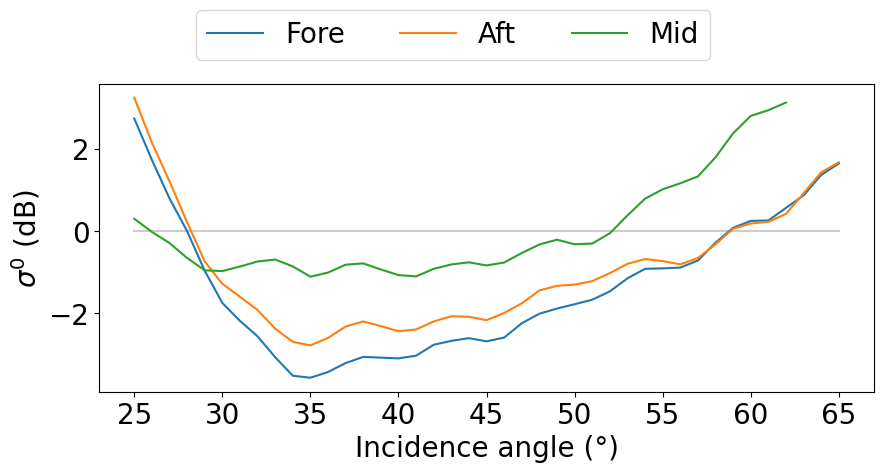

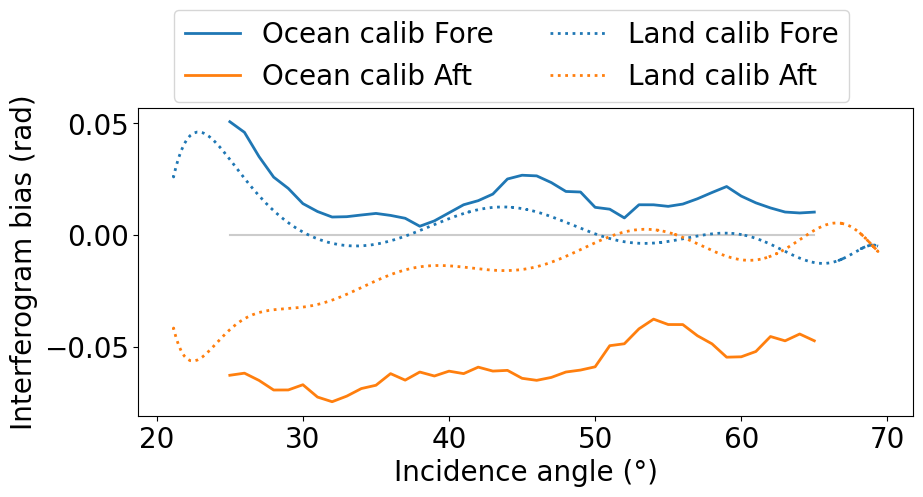

In [13]:
az = np.arange(0,360)
nscat_avg = [np.nan] * np.size(fit.inci.data)
aft_bias = [np.nan] * np.size(fit.inci.data)
mid_bias = [np.nan] * np.size(fit.inci.data)
fore_bias = [np.nan] * np.size(fit.inci.data)
aft_bias_log = [np.nan] * np.size(fit.inci.data)
fore_bias_log = [np.nan] * np.size(fit.inci.data)
mid_bias_log = [np.nan] * np.size(fit.inci.data)
for ii, inci_value in enumerate(fit.inci.data):
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(ss.gmfs.nrcs.nscat4ds(u10*ones, np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones, ones))
    nscat_avg[ii] = np.mean(nscat)
    fore_bias[ii] = np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0.data),# - nscat
        ) - db2lin(nscat_avg[ii]))
    aft_bias[ii] = np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0.data),# - nscat
        ) - db2lin(nscat_avg[ii]))
    fore_bias_log[ii] = lin2db(np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Sigma0.data)))) - nscat_avg[ii]
    aft_bias_log[ii] = lin2db(np.mean(db2lin(
        fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Sigma0.data)))) - nscat_avg[ii]  
    if inci_value <= 62:
        mid_bias[ii] = np.mean(db2lin(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0.data),# - nscat
            ) - db2lin(nscat_avg[ii]))
        mid_bias_log[ii] = lin2db(np.mean(db2lin(
            fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value).Sigma0.data)))) - nscat_avg[ii] 
fore_bias = np.array(fore_bias)
aft_bias = np.array(aft_bias)
mid_bias = np.array(mid_bias)
nscat_avg = np.array(nscat_avg)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1)
plt.plot([25,65],[0,0],c=[0.8,0.8,0.8])
plt.xlabel('Incidence angle ('+u'\N{DEGREE SIGN}'+')', fontsize=20)
plt.ylabel(r'$\sigma^0$ (dB)', fontsize=20)
plt.plot(fit.inci.data, fore_bias_log, color='C0',label='Fore')
plt.plot(fit.inci.data, aft_bias_log, color='C1',label='Aft')
plt.plot(fit.inci.data, mid_bias_log, color='C2',label='Mid')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=4,bbox_to_anchor=(0.75,1.1))

plt.show()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,1,1)
plt.plot([25,65],[0,0],c=[0.8,0.8,0.8])
plt.xlabel('Incidence angle ('+u'\N{DEGREE SIGN}'+')', fontsize=20)
plt.ylabel('Interferogram bias (rad)', fontsize=20)
plt.plot(fit.inci.data, fit.sel(parameters='A', Antenna=['Fore']).Interferogram.data.ravel(), color='C0',linewidth=2,label='Ocean calib Fore')
plt.plot(fit.inci.data, fit.sel(parameters='A', Antenna=['Aft']).Interferogram.data.ravel(), color='C1',linewidth=2,label='Ocean calib Aft')
plt.plot(ds_LandCalib.IncidenceAngle.data, ds_LandCalib.sel(Antenna='Fore').Interferogram.data,
         c='C0', linewidth=2, linestyle=':', label='Land calib Fore'
        )
plt.plot(ds_LandCalib.IncidenceAngle.data, ds_LandCalib.sel(Antenna='Aft').Interferogram.data,
         c='C1', linewidth=2, linestyle=':',label='Land calib Aft'
        )

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2,bbox_to_anchor=(0.85,1.16))
plt.show()

# Generate Ocean calibration dataset
### Build Ocean ncalibration datasets for Sigma0 and phase

In [14]:
def add_attributes(ds):
    ds['Antenna'].attrs['long_name']  = 'Antenna'
    ds['Antenna'].attrs['units']  = ''
    ds['Antenna'].attrs['description']  = 'Name of OSCAR antenna location'
    ds['IncidenceAngle'].attrs['long_name'] = 'Incidence angle'
    ds['IncidenceAngle'].attrs['units'] = 'deg'
    ds['IncidenceAngle'].attrs['description'] = 'Incidence angle between nadir and the ground'
    if 'Sigma0' in ds.variables:
        ds['Sigma0'].attrs['long_name'] = 'Sigma0 bias'
        ds['Sigma0'].attrs['description'] = 'Sigma0 bias with GMF'
        ds['Sigma0'].attrs['units'] = ''
    if 'Interferogram' in ds.variables:
        ds['Interferogram'].attrs['long_name'] = 'Interferogram bias'
        ds['Interferogram'].attrs['description'] = 'Azimuth-averaged Interferogram with respect to IncidenceAngle from star pattern fit'
        ds['Interferogram'].attrs['units'] = 'rad'
    ds.attrs['Codebase'] = 'seastar_project'
    ds.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
    ds.attrs['CodeVersion'] = __version__
    ds.attrs['DataVersion'] = version
    ds.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')
    ds.attrs['NRCSGMF'] = 'NSCAT-4DS'
    ds.attrs['Calibration'] = 'OceanPattern'
    return ds

def add_track_attributes(ds):
    ds['FilesUsed'] = xr.DataArray(data=build_tracks_used_file_list(['Track_' + str(track) for track in tracks_to_process]),
            coords={'Track':['Track_' + str(track) for track in tracks_to_process]},
            )
    ds['FilesUsed'].attrs['long_name'] = 'Files used'
    ds['FilesUsed'].attrs['description'] = 'Files used in ocean calibration star pattern fit'
    ds['FilesUsed'].attrs['units'] = ''
    ds.attrs['ReducedTrackLength'] = str(reduce_track_length)
    ds['StartTime'] = xr.DataArray(data=[format(ds_L1b[track].OrbTimeImage.sel(Antenna='Mid').mean(dim='GroundRange')[0].data, '.2f')
                                                  for track in ['Track_' + str(track) for track in tracks_to_process]],
                                            coords = ds.FilesUsed.coords,
                                           )
    ds['StartTime'].attrs['long_name'] = 'Start times'
    ds['StartTime'].attrs['description'] = 'Start times (GPS sec week) for each track used in ocean calibration star pattern fit'
    ds['StartTime'].attrs['units'] = 's'
    ds['EndTime'] = xr.DataArray(data=[format(ds_L1b[track].OrbTimeImage.sel(Antenna='Mid').mean(dim='GroundRange')[-1].data, '.2f')
                                                  for track in ['Track_' + str(track) for track in tracks_to_process]],
                                            coords = ds.FilesUsed.coords,
                                           )
    ds['EndTime'].attrs['long_name'] = 'End times'
    ds['EndTime'].attrs['description'] = 'End times (GPS sec week) for each track used in ocean calibration star pattern fit'
    ds['EndTime'].attrs['units'] = 's'
    ds['Track'].attrs['long_name'] = 'Tracks used'
    ds['Track'].attrs['description'] = 'Names of tracks used in star pattern fit for ocean calibration'
    ds['Track'].attrs['units'] = ''
    return ds

def reduced_track_timestr(start_time_string_new, end_time_string_new):
    pattern = r'(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<hour>\d{2}):(?P<minute>\d{2})'
    match_start = re.match(pattern, str(start_time_string_new))
    match_end = re.match(pattern, str(end_time_string_new))
    timestr = ''.join([match_start.group('year'),match_start.group('month'),match_start.group('day')])+'T'+'-'.join([match_start.group('hour')+match_start.group('minute'),                                                                                               match_end.group('hour')+match_end.group('minute')])
    return timestr
def timestrings(StartTime, EndTime):
    start_time_string = '-'.join([StartTime[0:4], StartTime[4:6],StartTime[6:8]]) + 'T' + ':'.join([StartTime[9:11], StartTime[11:13]])
    end_time_string = '-'.join([EndTime[0:4], EndTime[4:6],EndTime[6:8]]) + 'T' + ':'.join([EndTime[9:11], EndTime[11:13]])
    return start_time_string, end_time_string
def build_tracks_used_file_list(tracks):
    tracks_used_file_list = []
    for track in tracks:
        pattern = rf'.*_{re.escape(track)}_.*'
        tracks_used_file_list.append([f for f in L1B_file_list if re.match(pattern, f)][0])
    return tracks_used_file_list

ds_sigma0_calib = xr.Dataset()
ds_interferogram_ocean_calib = xr.Dataset()

ds_sigma0_calib['Sigma0'] = xr.concat([xr.DataArray(data=fore_bias_log, dims=["IncidenceAngle"],
                                                  coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                     xr.DataArray(data=aft_bias_log, dims=["IncidenceAngle"],
                                                  coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                     xr.DataArray(data=mid_bias_log, dims=["IncidenceAngle"],
                                                  coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                    ],pd.Index(['Fore', 'Aft', 'Mid'], name="Antenna"))


ds_interferogram_ocean_calib['Interferogram'] = xr.concat([xr.DataArray(
    data=fit.sel(parameters='A', Antenna=['Fore']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                       xr.DataArray(
    data=fit.sel(parameters='A', Antenna=['Aft']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                       xr.DataArray(
    data=fit.sel(parameters='A', Antenna=['Mid']).Interferogram.data.ravel(),
    dims=["IncidenceAngle"],
    coords=dict(IncidenceAngle=(["IncidenceAngle"], fit.inci.data))),
                                      ],pd.Index(['Fore', 'Aft', 'Mid'], name="Antenna"))

ds_sigma0_calib = add_attributes(ds_sigma0_calib)
ds_sigma0_calib = add_track_attributes(ds_sigma0_calib)
ds_interferogram_ocean_calib = add_attributes(ds_interferogram_ocean_calib)
ds_interferogram_ocean_calib = add_track_attributes(ds_interferogram_ocean_calib)
print('Done...')

Done...


# Save calibration datasets

In [15]:
save_folder = os.path.join(file_paths['oscar_path'], campaign, 'calib', version)

#--------------------OceanPattern NRCS------------------------------------
save_name = '_'.join(['Cal', 'OSCAR', 'OceanPattern', 'NRCS', flight, 'Tracks' + str(tracks_to_process[0]) + '-' + str(tracks_to_process[-1]) ,version]) + '.nc'
print('Saving...' + os.path.join(save_folder, save_name))
ds_sigma0_calib.to_netcdf(os.path.join(save_folder, save_name))
#--------------------OceanPattern Interferogram------------------------------------
save_name = '_'.join(['Cal', 'OSCAR', 'OceanPattern', 'Interferogram', flight, 'Tracks' + str(tracks_to_process[0]) + '-' + str(tracks_to_process[-1]), version]) + '.nc'
print('Saving...' + os.path.join(save_folder, save_name))
ds_interferogram_ocean_calib.to_netcdf(os.path.join(save_folder, save_name))
#--------------------LandCalib Interferogram------------------------------------
save_name = '_'.join(['Cal', 'OSCAR', 'LandCalib', 'Interferogram', flight, 'TrackL1', version]) + '.nc'
print('Saving...' + os.path.join(save_folder, save_name))
ds_LandCalib.to_netcdf(os.path.join(save_folder, save_name))

Saving...C:\data\OSCAR\202305_MedSea\calib\v20250312\Cal_OSCAR_OceanPattern_NRCS_20230508_Tracks1-10_v20250312.nc
Saving...C:\data\OSCAR\202305_MedSea\calib\v20250312\Cal_OSCAR_OceanPattern_Interferogram_20230508_Tracks1-10_v20250312.nc
Saving...C:\data\OSCAR\202305_MedSea\calib\v20250312\Cal_OSCAR_LandCalib_Interferogram_20230508_TrackL1_v20250312.nc


# Plot Sigma0 Star Pattern
### Plots Star Pattern Sigma0 data

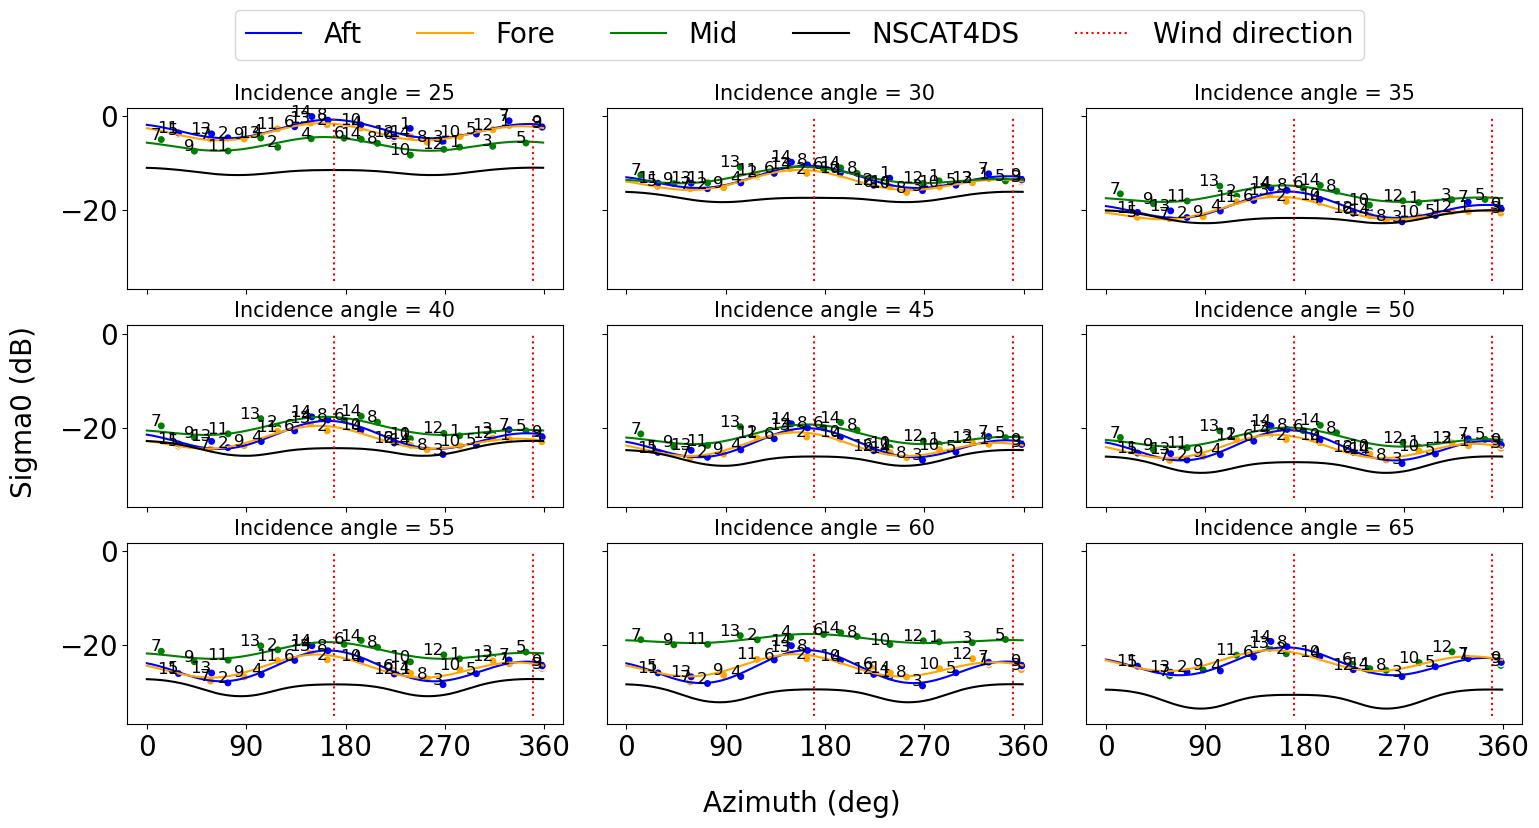

In [13]:
var = 1
var_to_plot = {1:'Sigma0',2:'Intensity'}[var]


fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True,
                        sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange','green']
ylim=[-35,0]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value)\
        .plot.scatter(x='azimuth',y=var_to_plot, hue='Antenna',ax=axs[ii], add_colorbar=False,
                     cmap=mpl.colors.ListedColormap(colors))
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value)[var_to_plot].data),
                 'blue', label='Aft')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value)[var_to_plot].data),
                 'orange', label='Fore')
    if inci_value <= 62:
        axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Mid', inci=inci_value)[var_to_plot].data),
                 'green', label='Mid')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    # plot dummy curve
#     axs[ii].plot(az, fit_func_simple(az, -15, 0.1, 0.2, updir), '--k')
    # plot nscat
    ones = np.ones(np.size(az))
    nscat = 10*np.log10(
            ss.gmfs.nrcs.nscat4ds( 
                u10*ones,
                np.abs(np.mod(az - updir +180, 360) - 180),
                inci_value*ones,
                ones
            )
    )
    axs[ii].plot(az, nscat, 'k',label='NSCAT4DS')
    axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    axs[ii].plot([np.mod(updir+180, 360), np.mod(updir+180, 360)], ylim,'red', linestyle='dotted')
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    for i_ant, ant in enumerate(nds.Antenna.values):
        for i_track, track_num in enumerate(nds.Track.values):
            axs[ii].text(nds.azimuth.sel(Antenna=ant).values[i_track],
                     nds.Sigma0.sel(inci=inci_value).sel(Antenna=ant).values[i_track],
                     f'{track_num}', fontsize=12, ha='right')
fig.text(0.5, 0, 'Azimuth (deg)', ha='center')
fig.text(0.06, 0.5, 'Sigma0 (dB)', va='center', rotation='vertical')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5,bbox_to_anchor=(0.82,1.02))
#plt.savefig(fig_folder + 'Intensity.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot Interferogram
### Plot Star Pattern Interferogram data

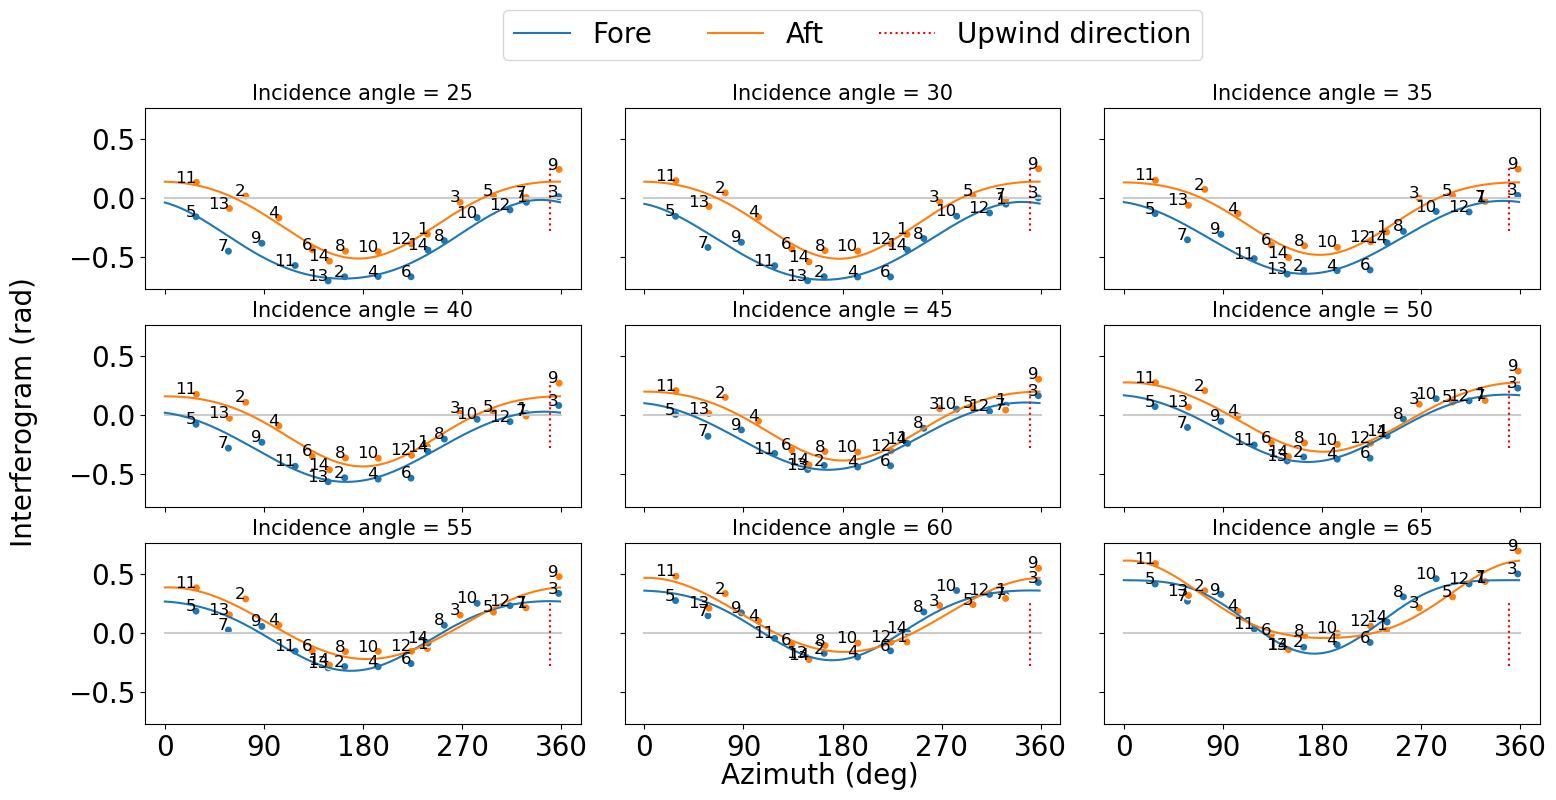

In [14]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['C1','C0']
ylim=[-0.28,0.28]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='Interferogram', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors),
                                         )

#     axs[ii].plot(az,)
    axs[ii].plot([0,360],[0,0],c=[0.8,0.8,0.8])
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Fore', inci=inci_value).Interferogram.data),
                 'C0', label='Fore')
    axs[ii].plot(az, fit_func_simple2(az, *fit.sel(Antenna='Aft', inci=inci_value).Interferogram.data),
                 'C1', label='Aft')
    
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    axs[ii].plot([updir, updir], ylim,'red', label='Upwind direction', linestyle='dotted')

    for i_ant, ant in enumerate(nds.Antenna.values):
        for i_track, track_num in enumerate(nds.Track.values):
            axs[ii].text(nds.azimuth.sel(Antenna=ant).values[i_track],
                     nds.Interferogram.sel(inci=inci_value).sel(Antenna=ant).values[i_track],
                     f'{track_num}', fontsize=12, ha='right')
    
fig.text(0.5, 0.035, 'Azimuth (deg)', ha='center')
fig.text(0.05, 0.5, 'Interferogram (rad)', va='center', rotation='vertical')

handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3,bbox_to_anchor=(0.72,1.02))
#plt.savefig(fig_folder + 'Interferogram_nocalib.png', dpi=150, bbox_inches='tight')

# Plot Coherence
### Plot Star Pattern Coherence data

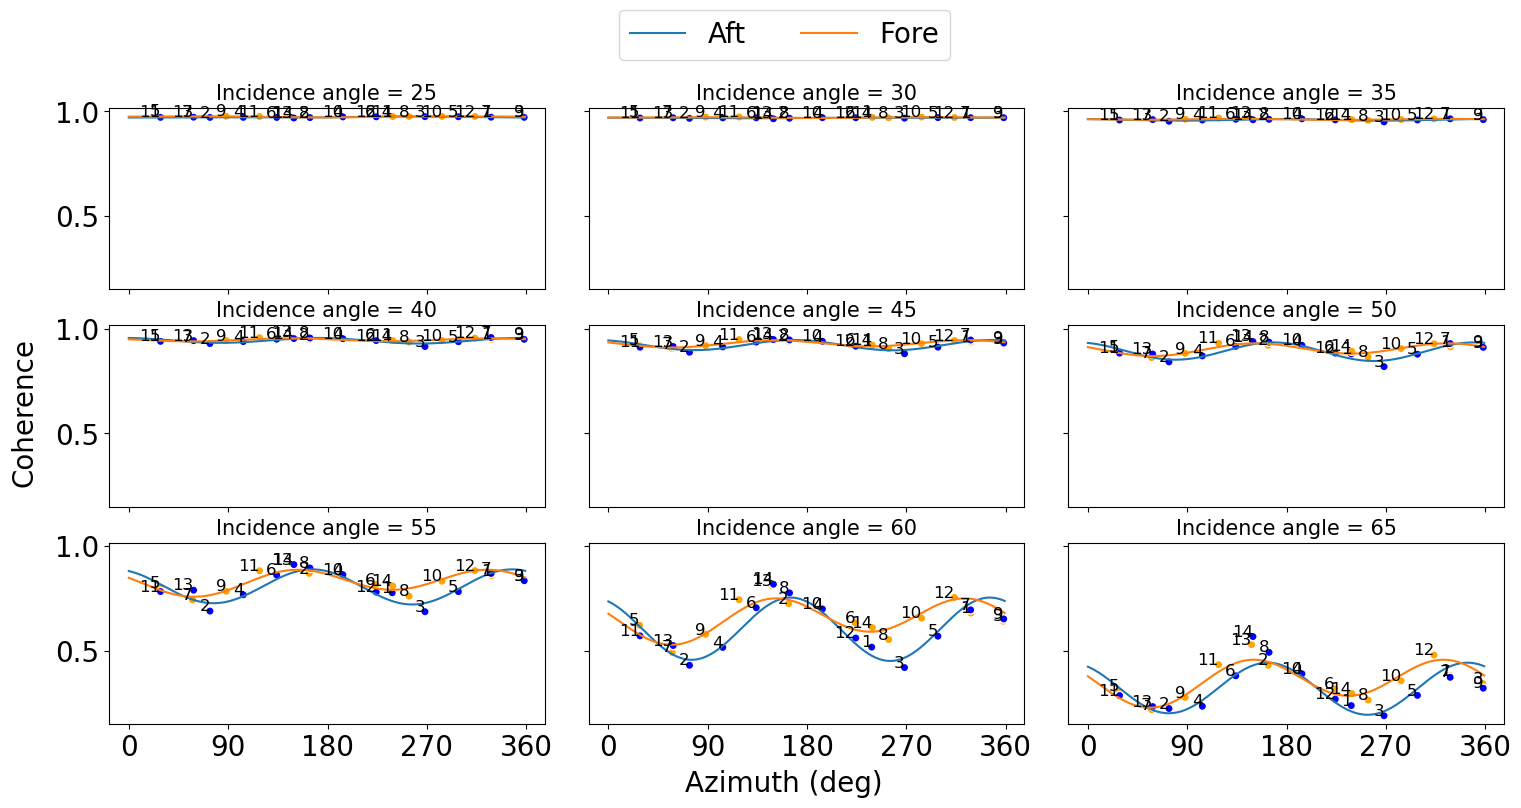

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(18,8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.2, 'wspace': 0.1})
axs = axs.ravel()
colors=['blue','orange']
ylim=[0.55,1.01]
for ii, inci_value in enumerate(np.arange(25,66,5)):
    nds.sel(inci=inci_value).plot.scatter(x='azimuth',y='Coherence', hue='Antenna',
                                          ax=axs[ii], add_colorbar=False,
                                         cmap=mpl.colors.ListedColormap(colors))
#     axs[ii].plot(az,)
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Aft', inci=inci_value).Coherence.data),
                 'C0',label='Aft')
    axs[ii].plot(az, fit_func_simple(az, *fit.sel(Antenna='Fore', inci=inci_value).Coherence.data),
                 'C1',label='Fore')
    axs[ii].set_xticks(np.arange(0,360,45))
    axs[ii].set_title('Incidence angle = ' + str(inci_value), fontsize=15)
    #axs[ii].plot([updir, updir], ylim,'red', label='Wind direction', linestyle='dotted')
    #axs[ii].plot([updir+180, updir+180], ylim,'red', linestyle='dotted')  
    #axs[ii].legend(fontsize=10, loc='upper right')
    axs[ii].get_legend().remove()
    axs[ii].set(xlabel=None, ylabel=None)
    plt.xticks([0,90,180,270,360])
    #plt.yticks([0,0.5,1])
    for i_ant, ant in enumerate(nds.Antenna.values):
        for i_track, track_num in enumerate(nds.Track.values):
            axs[ii].text(nds.azimuth.sel(Antenna=ant).values[i_track],
                     nds.Coherence.sel(inci=inci_value).sel(Antenna=ant).values[i_track],
                     f'{track_num}', fontsize=12, ha='right')
fig.text(0.5, 0.025, 'Azimuth (deg)', ha='center')
fig.text(0.07, 0.5, 'Coherence', va='center', rotation='vertical')
handles, labels = axs[ii].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3,bbox_to_anchor=(0.6,1.02))
# plt.savefig(fig_folder + 'Coherence.png', dpi=150, bbox_inches='tight')